# Micrograd-From-Scratch

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def f(x):
    return 3*x**2 -4*x + 5

In [13]:
f(3.0)

20.0

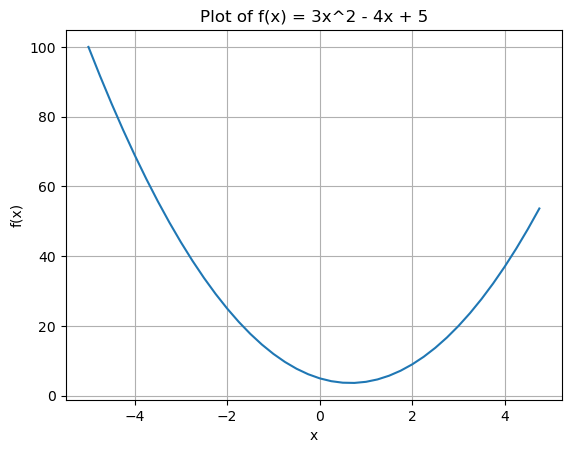

In [14]:
xs = np.arange(-5,5, 0.25)# Generate a range of x values
ys = f(xs) # Compute the corresponding y values
plt.plot(xs, ys)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Plot of f(x) = 3x^2 - 4x + 5')
plt.grid()
plt.show()

In [17]:
h = 0.000001
x = -3
(f(x + h) - f(x))/h

-21.999997002808414

In [18]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [19]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694
